# Analysis

In [348]:
import warnings
import pandas as pd
import geopandas as geo
import numpy as np
from tqdm import tqdm
import os
import plotly.express as px
import uuid
import osmnx as ox
from keplergl import KeplerGl
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPolygon, MultiPoint
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent="myGeocoder")
import requests

warnings.simplefilter(action='ignore', category=FutureWarning)

#osmnx config timeout
timeout = 3000
ox.config(timeout=timeout)

nws_region = pd.read_csv('data_dir/nws_region_codes.csv')
state_ab = pd.read_csv('data_dir/state_abbv.csv')
counties = geo.read_file('data_dir/c_13se22/c_13se22.shp')

#### create dictionary from NWS alerts, add geocodes ####

w_d = {'state': [], 'area': [], 'event':[], 'sent':[], 'onset':[], 'ends':[], 'geocode': [], 'severity': [],
       'certainty':[], 'urgency':[], 'headline': [], 'descr': []}

for ab in state_ab.state_abbv:
    url = f'https://api.weather.gov/alerts/active?area={ab}'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
    else:
        print(f'Error: {response.status_code}')
       
    for i in data['features']:
        #print(i['properties'])
        if i['properties']['severity'] == 'Severe':
            state = ab
            w_d['state'].append(state)
            area = i['properties']['areaDesc']
            w_d['area'].append(area)
            event = i['properties']['event']
            w_d['event'].append(event)
            sent = i['properties']['sent']
            w_d['sent'].append(sent)
            onset = i['properties']['onset']
            w_d['onset'].append(onset)
            ends = i['properties']['ends']
            w_d['ends'].append(ends)
            geocode = i['properties']['geocode']['SAME']
            w_d['geocode'].append(geocode)
            severity = i['properties']['severity']
            w_d['severity'].append(severity)
            urgency = i['properties']['urgency']
            w_d['urgency'].append(urgency)
            certainty = i['properties']['certainty']
            w_d['certainty'].append(certainty)
            headline = i['properties']['headline']
            w_d['headline'].append(headline)
            descr = i['properties']['description']
            w_d['descr'].append(descr)
            
report = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in w_d.items() ]))
report['sent'] = pd.to_datetime(report['sent'], utc = True)
report['onset'] = pd.to_datetime(report['onset'], utc = True)
report['ends'] = pd.to_datetime(report['ends'], utc = True)
report.to_csv('report.csv')

#take all geocodes associated with report, and match then to FIPS geocodes from Counties shp


affected = []

for i in report['geocode'].iloc[0:]:
    no_zeros = [zero.lstrip('0') for zero in i]
    for nzero in no_zeros:
        affected.append(nzero)
        
affected_nd = list(set(affected))
affected_nd.sort(reverse = False)


affected_counties = geo.GeoDataFrame()

try:
    for f in affected_nd:
        counties['FIPS'] = counties['FIPS'].str.lstrip('0')
        county = counties[(counties['FIPS'] == f)]
        affected_counties = affected_counties.append(county)
except FutureWarning:
    pass

### prep the data, perform a table merge on counties and report

report = report.explode('geocode')
report = report.drop_duplicates(subset = ['geocode', 'event', 'area'])
report['geocode'] = report['geocode'].str.lstrip('0')
merged_affected = pd.merge(report, affected_counties, left_on='geocode', right_on='FIPS', how='left')
geo_merge = geo.GeoDataFrame(merged_affected, geometry='geometry')
geo_merge.to_csv('geo_merge.csv')
geo_merge = geo_merge.to_crs({'init': 'epsg:4326'})

### using the unique geocodes from the report, pull osm geometries (power : plant) ###

affected_utilities = geo.GeoDataFrame()

for code in geo_merge['geocode'].unique():
    geo_u = geo_merge[(geo_merge.geocode == code)]
    geom = geo_u.geometry.iloc[0]
    tags = {'power': 'plant'}        
    osm_pull = ox.geometries.geometries_from_polygon(geom, tags)
    osm_pull.reset_index(inplace = True)
    affected_utilities = pd.concat([affected_utilities, osm_pull])
    affected_utilities.to_csv('affected_utilities.csv')

#select only a few rows
v_utils = affected_utilities[['geometry', 'name', 'operator', 'plant:source', 'plant:method',
                              'plant:output:electricity',  'source', 'osmid', 'element_type', 'power']]

#perform a spatial merge on the returned osm_boundaries and the merged file, delete dupes

prod = geo.GeoDataFrame(v_utils, geometry='geometry')
merged = geo.sjoin(prod, geo_merge, how='inner', op='intersects')
final = merged.drop_duplicates(subset = 'osmid')
final['centroid'] = final['geometry'].centroid
final['descr'] = final['descr'].str.wrap(500)
final = final.fillna('NA')

#more cleaning
final['certainty_n'] = ''
final['urgency_n'] = ''
final['certainty_n'] = final['certainty'].apply(lambda x: 3 if x == 'Observed' else (2 if x == 'Likely' else (1 if x == 'Possible' else None)))
final['urgency_n'] = final['urgency'].apply(lambda x: 3 if x == 'Immediate' else (2 if x == 'Expected' else (1 if x == 'Future' else None)))
final.to_csv('final.csv')
final.head()

# query only major threats
query = final[(final.certainty == 'Observed') | (final.urgency == 'Immediate')]

/opt/anaconda3/lib/python3.9/site-packages/osmnx/utils.py:192: UserWarning:

The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.

/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning:

CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).

/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning:

CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).

/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning:

CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).

/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning:

CRS not set for some of the c

# Maps

/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



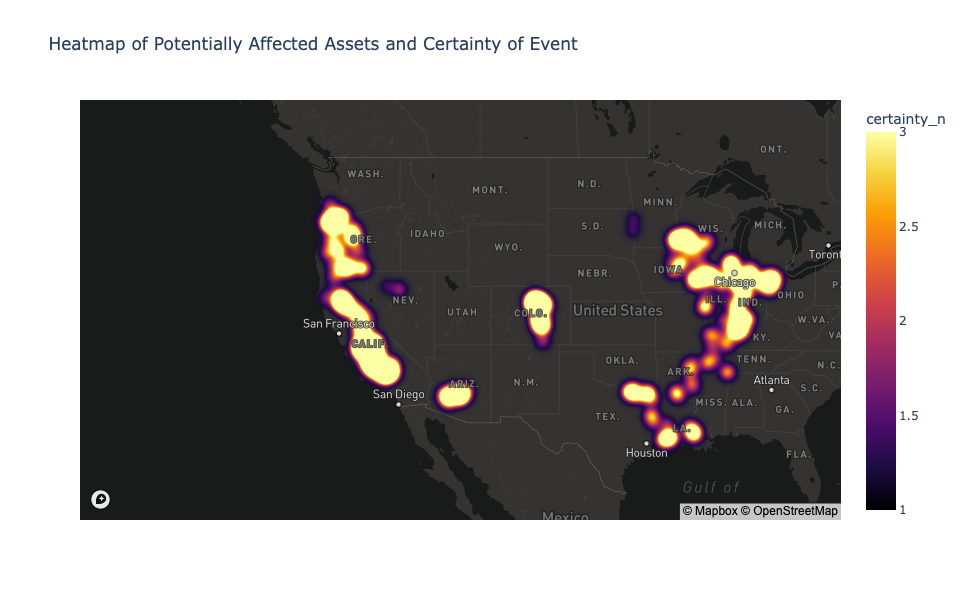

In [351]:
fig = px.density_mapbox(final, lat=final['centroid'].y, lon=final['centroid'].x, z='certainty_n', radius=15,
                        color_continuous_scale=px.colors.sequential.Inferno, zoom=3, hover_name = 'event',
                        mapbox_style="dark", title = 'Heatmap of Potentially Affected Assets and Certainty of Event')
fig.update_layout(
    width=1100, 
    height=600 
)
fig.show()

/var/folders/pc/jgv4sqmj6w90dvgdt46fm7xw0000gp/T/ipykernel_40898/266784229.py:1: ResourceWarning:

unclosed file <_io.TextIOWrapper name='mapbox_token.txt' mode='r' encoding='UTF-8'>

/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



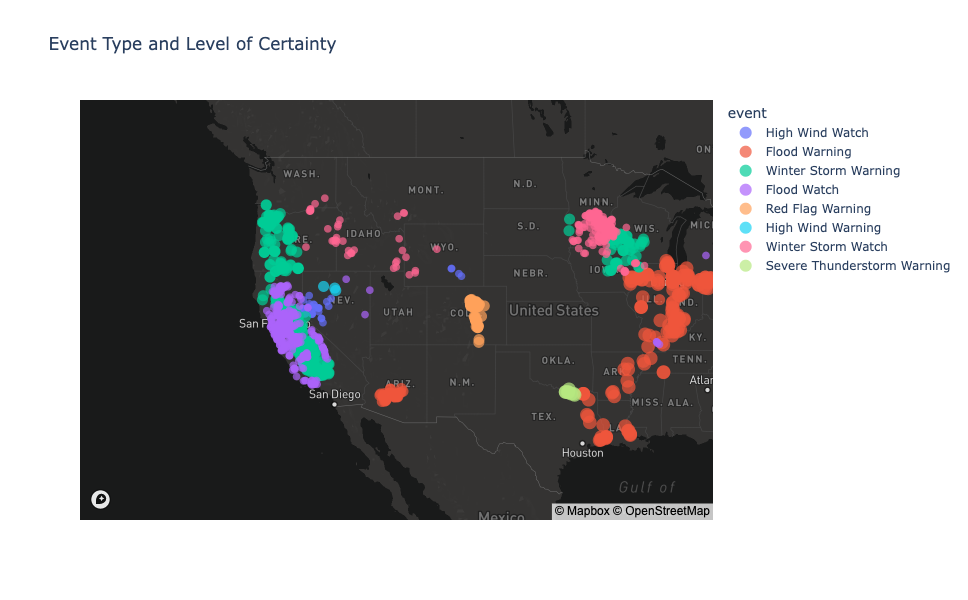

In [353]:
px.set_mapbox_access_token(open("mapbox_token.txt").read())

fig = px.scatter_mapbox(final, lat=final['centroid'].y, lon=final['centroid'].x, hover_name = 'name', 
                        color_continuous_scale=px.colors.sequential.Turbo, mapbox_style="dark",
                        color = 'event', size= 'certainty_n', size_max=10, zoom=3, title= 'Event Type and Level of Certainty')
fig.update_layout(
    width=1100, 
    height=600 
)
fig.show()

/var/folders/pc/jgv4sqmj6w90dvgdt46fm7xw0000gp/T/ipykernel_40898/1204532432.py:1: ResourceWarning:

unclosed file <_io.TextIOWrapper name='mapbox_token.txt' mode='r' encoding='UTF-8'>

/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



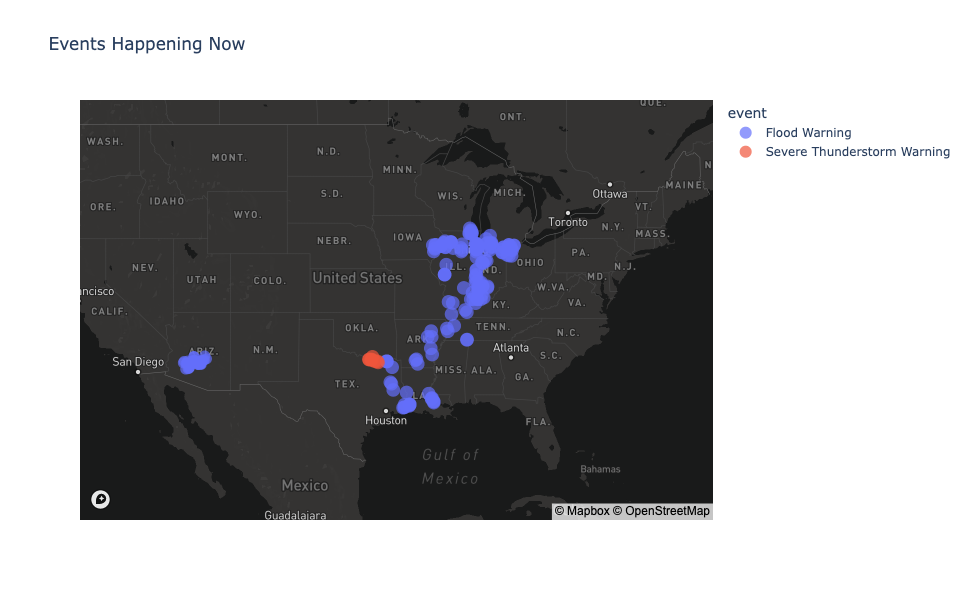

In [357]:
px.set_mapbox_access_token(open("mapbox_token.txt").read())

fig = px.scatter_mapbox(query, lat=query['centroid'].y, lon=query['centroid'].x, hover_name = 'name', 
                        color_continuous_scale=px.colors.sequential.Turbo, mapbox_style="dark",
                        color = 'event', size= 'certainty_n', size_max=10, zoom=3, title= 'Events Happening Now')
fig.update_layout(
    width=1100, 
    height=600 
)
fig.show()

# MORE PLOTS

/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



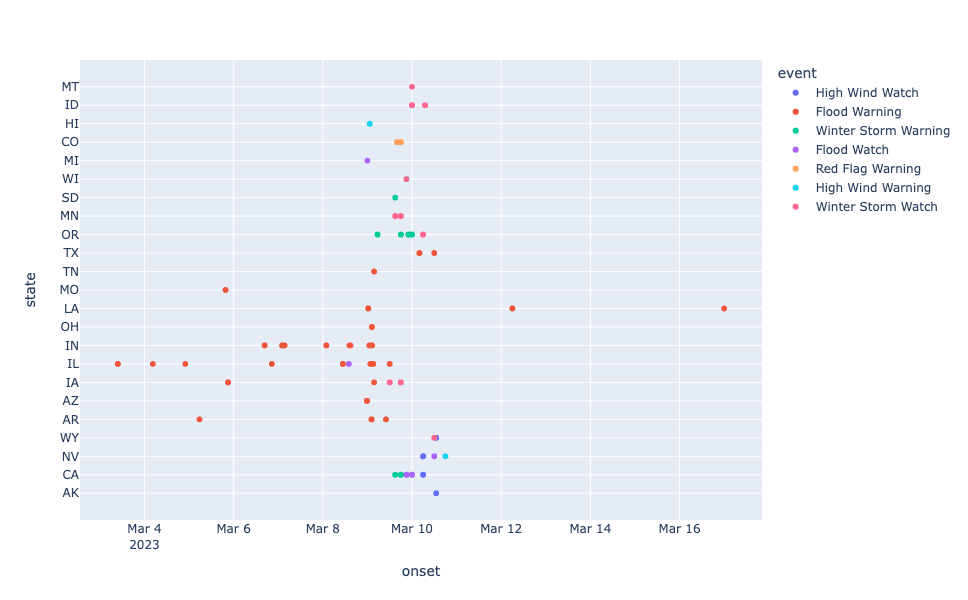

In [310]:
fig = px.scatter(final, x = 'onset', y = 'state', color = 'event')
fig.update_layout(
    width=1000, # Set the width of the plot to 800 pixels
    height=600 # Set the height of the plot to 600 pixels
)

/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



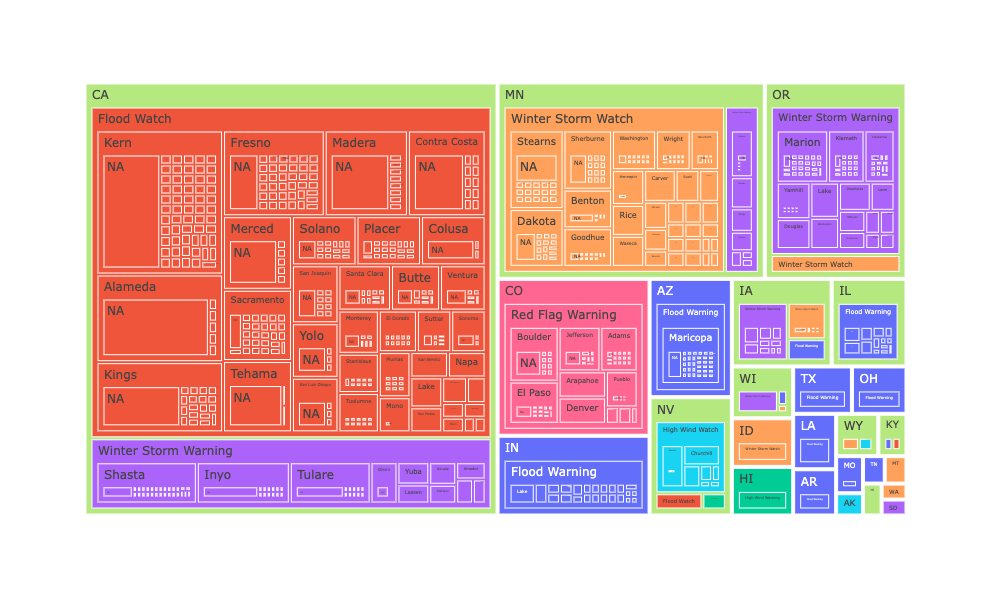

In [243]:
fig = px.treemap(final, path = ['STATE','event', 'COUNTYNAME', 'name'], color = 'event')
fig.update_layout(
    width=1000, # Set the width of the plot to 800 pixels
    height=600 # Set the height of the plot to 600 pixels
)
fig.show()

/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



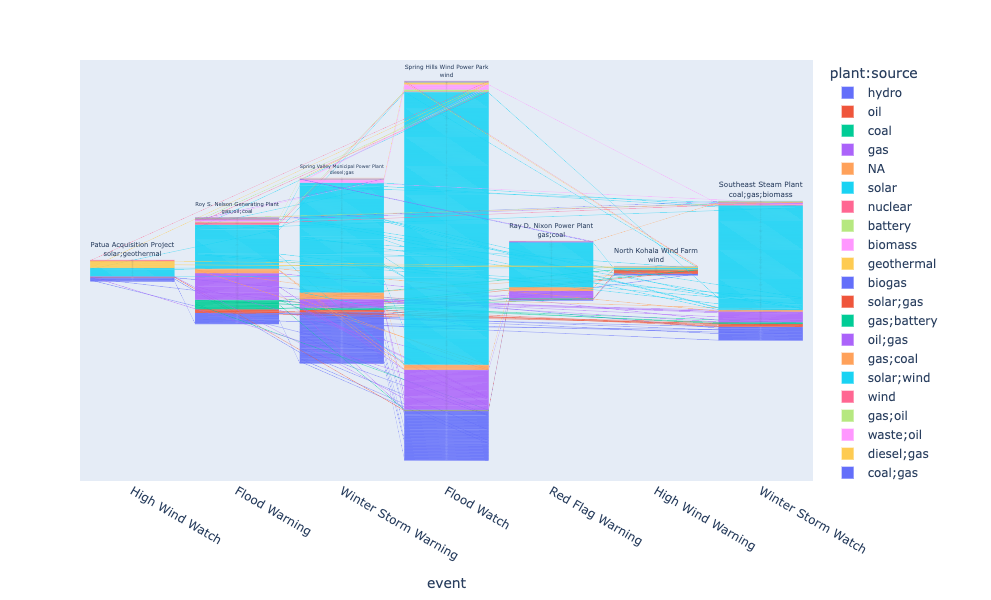

In [244]:
fig = px.funnel(final, x='event', y='plant:source', color = 'plant:source', hover_name = 'name', text = 'name')
fig.update_layout(
    width=1000, # Set the width of the plot to 800 pixels
    height=600 # Set the height of the plot to 600 pixels
)
fig.show()

In [345]:
'''
import pandas as pd

# Create sample dataframe
df = pd.DataFrame({'description': ['This is a description about apples and bananas.', 'This is another description that mentions bananas but not apples.']})

# Use regular expressions to extract 'apple' and 'banana' from 'description' column
df['has_apple'] = df['description'].str.extract('(apple)', flags=re.IGNORECASE).notna()
df['has_banana'] = df['description'].str.extract('(banana)', flags=re.IGNORECASE).notna()

# Display updated dataframe
print(df)
'''

"\nimport pandas as pd\n\n# Create sample dataframe\ndf = pd.DataFrame({'description': ['This is a description about apples and bananas.', 'This is another description that mentions bananas but not apples.']})\n\n# Use regular expressions to extract 'apple' and 'banana' from 'description' column\ndf['has_apple'] = df['description'].str.extract('(apple)', flags=re.IGNORECASE).notna()\ndf['has_banana'] = df['description'].str.extract('(banana)', flags=re.IGNORECASE).notna()\n\n# Display updated dataframe\nprint(df)\n"

In [354]:
### Next steps, maybe query tweets for that particulat location?
###
### figure out how to encorporate spark 
### figure out the applicability level with flask 